In [3]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Rademacher complexity of neural networks

Here we explore how the Rademacher complexity works. The Rademacher complexity provides an extension over the VC dimensions to measure the complexity of an hypothesis class. Where VC dimensions refer to "how many data points can I scatter?", the Rademacher complexity refers to "how many data points am I likely to scatter?".

This complexity measure comes of use in hypothesis classes of infinite dimension. Common models like neural networks have, seemingly, infinite VC dimension. Yet, one neural network class seems easier to overfit than another. 

Particularly, we explore how the prior of neural network weights influences the Rademacher complexity. We show by experiment that a wider prior on network weights results in a higher Rademacher complexity (and thus a looser bound on the generalization gap)

In [4]:
def sigmoid(x):
    # logistic sigmoid function. 0 at -infinity, 1 at +infinity
    return 1 / (1 + np.exp(-x))


In [5]:

# Set up a forward pass of a neural net
num_features = 30  # Given, hard-coded, number of features in our data
num_samples = 100  # How many data samples will our (synthetic) data set have?

num_neurons = 100  # Number of neurons in the neural net
std_weight = 0.1  # prior variance over the weights


def nn_forward(x, W1, b1, W2):
    """
    Calculates the decisions {0, 1} for the neural network
    
    :param x: data matrix in size [num_samples, num_features]
    :param W1: weight for the first layer, in size [num_features, num_neurons]
    :param b1: biases for the first layer, in size [num_neurons]
    :param W2: weights for the second layer, in size [num_neurons, 1]
    """
    assert len(x.shape) == 2
    logit = sigmoid(x @ W1 + b1) @ W2
    return (logit > 0).astype(np.int)  # Resulting matrix in size [num_samples, 1]


# Make random data set
data = np.random.rand(num_samples, num_features)
labels = np.random.randint(low=0, high=2, size=(num_samples,))


def loss_per_sample(pred_func, data_, labels_):
    """
    Calculate the loss per sample.
    :param pred_func: the prediction function. Should map data to labels in {0, 1}
    :param data_: incoming data matrix in size [num_samples, num_features]
    :param labels_: incoming labels, matrix in size [num_samples], values in {0, 1}
    """
    return (pred_func(data) != labels).astype(np.int)


# Calculate complexity
num_mc = 100  # Number of MC samples to approximate the expectation over sigmas

# Make an hypothesis set
num_hypotheses = 12
W1s = [std_weight * np.random.randn(num_features, num_neurons) for _ in range(num_hypotheses)]
b1s = [std_weight * np.random.randn(num_neurons) for _ in range(num_hypotheses)]
W2s = [std_weight * np.random.randn(num_neurons) for _ in range(num_hypotheses)]
hypothesis_set = list(zip(W1s, b1s, W2s))


def rademacher_estimates(hypothesis_set_):
    """
    Generator function to yield estimates of the Rademacher complexity, under SAMPLING of the sigmas.
    :return: scalar, being an estimate for the Rademacher complexity for one realization of sigmas
    """
    for n in range(num_mc):  # Do MC sampling. Total enumeration would be 2^num_samples atoms
        # Get an estimate for one realization of sigmas
        sigmas = np.random.randint(low=0, high=2, size=(num_samples,)) * 2 - 1  # Random indicators in {-1, 1}
        
        # Get the supremum over all hypotheses of the instant Rademacher complexity
        r_est = max((loss_per_sample(lambda x: nn_forward(x, *hypothesis), data, labels) @ sigmas 
                     for hypothesis in hypothesis_set_))
        yield r_est / num_samples  # Division carries over max, so compute it afterwards

0.04100000000000003


In [6]:
# Utility functions
def rademacher_cpx(hypos):
    # Average. (get the Monte Carlo estimate)
    return sum(rademacher_estimates(hypos)) / num_mc

def rademacher_percentiles(hypos):
    # Get percentile statistics
    return np.percentile(list(rademacher_estimates(hypos)), [10, 50, 90])


print(rademacher_cpx(hypothesis_set))


## Rademacher complexity of increasing prior width

We experiment with increasing the prior width on the Rademacher complexity. Our prior width expresses how "funky" the neural network hypotheses can be. A neural network with higher variance in weights can make more funky, high frequency functions. As such, we see the Rademacher complexity increase.

/home/rob/Documents/environments/ml_cpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


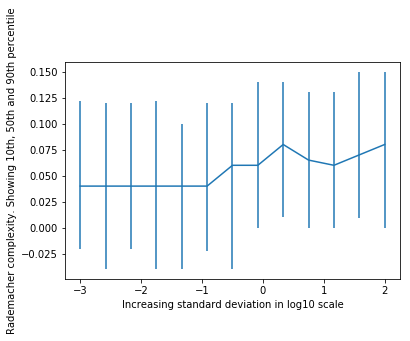

In [7]:
all_percentiles = []

log_std_spread = np.linspace(-3, 2, num=13)  # Spread of log standard deviations to probe
for log_std_run in log_std_spread:
    std_run = 10**log_std_run  # Scale back from log to linear domain
    
    # Make an hypothesis set
    W1s = [std_run * np.random.randn(num_features, num_neurons) for _ in range(num_hypotheses)]
    b1s = [std_run * np.random.randn(num_neurons) for _ in range(num_hypotheses)]
    W2s = [std_run * np.random.randn(num_neurons) for _ in range(num_hypotheses)]
    hypothesis_set = list(zip(W1s, b1s, W2s))

    all_percentiles.append(rademacher_percentiles(hypothesis_set))

# Get the error bars for plotting
all_percentiles = np.array(all_percentiles)
errors = np.abs((all_percentiles[:, (0, 2)]).T - all_percentiles[:, 1])  # Errors are distances from the 50th percentile

# Matplotlib magic
plt.errorbar(log_std_spread, all_percentiles[:, 1], yerr=errors)
plt.xlabel('Increasing standard deviation in log10 scale')
plt.ylabel('Rademacher complexity. Showing 10th, 50th and 90th percentile')
plt.show()

## Rademacher complexity of increasing prior width

We experiment with increasing the number of neurons on the Rademacher complexity. My hypothesis would be that more neurons can also create more funky hypotheses. The universal approximation theorem of neural networks informs us that neural networks can approximate any function, provided enough hidden neurons. As such, my hypothesis arose that more neurons would yield an hypothesis class with higher complexity. However, this experiment does not show such results. This observation remains an open question to me?

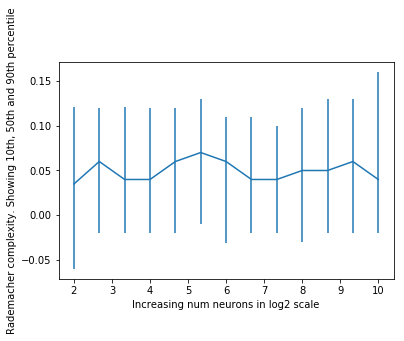

In [8]:
all_percentiles = []

log_num_neurons_spread = np.linspace(2, 10, num=13)  # Spread of log number of neurons to probe
for log_num_neurons in log_num_neurons_spread:
    num_neurons = int(2**log_num_neurons)
    
    # Make an hypothesis set
    W1s = [std_weight * np.random.randn(num_features, num_neurons) for _ in range(num_hypotheses)]
    b1s = [std_weight * np.random.randn(num_neurons) for _ in range(num_hypotheses)]
    W2s = [std_weight * np.random.randn(num_neurons) for _ in range(num_hypotheses)]
    hypothesis_set = list(zip(W1s, b1s, W2s))

    all_percentiles.append(rademacher_percentiles(hypothesis_set))

# Get the error bars for plotting
all_percentiles = np.array(all_percentiles)
errors = np.abs((all_percentiles[:, (0, 2)]).T - all_percentiles[:, 1])  # Errors are distances from the 50th percentile

# Matplotlib magic
plt.errorbar(log_num_neurons_spread, all_percentiles[:, 1], yerr=errors)
plt.xlabel('Increasing num neurons in log2 scale')
plt.ylabel('Rademacher complexity. Showing 10th, 50th and 90th percentile')
plt.show()